This notebook is about single gene spatial statistics, it allows to characterize, one gene at a time the distribution of 
rna's in the cells. 

Before running this notebook, be sure to have run Segmentation postprocessing both for cellbodies and for nuclei.

    Jacques Bourg @ Florian Muller lab. Institut Pasteur.


<div style="background-color: white; padding: 10px;">
    <img src="./pipeline.png" alt="pipeline" width="1200" height="420">
</div>

In [1]:
import sys
import os
import numpy as np
import napari
from skimage import io
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../pipeline/src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "segmentation"))
sys.path.append(str(base_dir / "synthesis"))

from segmentation.refine_seg import Segmentation
from synthesis.synthesize import Synthesis
from utils.plots import Plots
from utils.parameters_tracking import Parameter_tracking as Track
from utils.file_handling import FileProcessor

sg  = Segmentation()
pts = Plots()
tk  = Track()
fp  = FileProcessor()
st  = Synthesis()

In [3]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('kraken_old', 'kraken…

In [4]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']; print(batch_name)

kraken


In [5]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('KRAKEN',), value='KR…

In [6]:
n2       = np.where(np.array(modalities) == dropdown2.value)[0][0] 
modality = modalities[n2]; print(modality)

KRAKEN


Select channels used to detect dots (corresponding to a particular gene or simply called FISH). DAPI do not makes sense.

In [7]:
channels_fish = constants['CHANNELS'] #  (could also be FISH_0, FISH_1, ... or even different genes names), DAPI doesn't make sense
dropdown3 = widgets.Dropdown(options=channels_fish, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH'), valu…

In [8]:
n3     = np.where(np.array(channels_fish) == dropdown3.value)[0][0]
chan_f = channels_fish[n3]; print(chan_f)
chan_n = constants["CHANNELS_NUM"][n3]
color  = constants["COLORS"][n3]; print(color)               

FISH
green


#### channel used to segment cell: 

In [9]:
channels_cell = constants['CHANNELS'] #  (could also be FISH_0, FISH_1, ... or even different genes names), DAPI doesn't make sense
dropdown3b = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown3b)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH'), valu…

In [10]:
n3b    = np.where(np.array(channels_cell) == dropdown3b.value)[0][0]
chan_c = channels_fish[n3b]; print(chan_c)
chan_n = constants["CHANNELS_NUM"][n3b]
color  = constants["COLORS"][n3b]; print(color)    

FISH
green


Select nuclei

In [11]:
structs   = constants['STRUCTURES'] 
dropdown6 = widgets.Dropdown(options=structs, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown6)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('NUCLEI', 'CELL'), va…

In [12]:
n6   = np.where(np.array(structs) == dropdown6.value)[0][0]
struc_nuc = structs[n6]; print(struc_nuc)

NUCLEI


Select the channel used to detect the nuclei

In [13]:
channels_nuc = constants['CHANNELS'] #   choose DAPI, FISH doesn't make sense
dropdown_n = widgets.Dropdown(options=channels_nuc, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown_n)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH'), valu…

In [14]:
n_nuc    = np.where(np.array(channels_nuc) == dropdown_n.value)[0][0]
chan_nuc = channels_nuc[n_nuc]; print(chan_nuc)

DAPI


Select the cell

In [15]:
structs   = constants['STRUCTURES'] 
dropdown7 = widgets.Dropdown(options=structs, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown7)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('NUCLEI', 'CELL'), va…

In [16]:
n7         = np.where(np.array(structs) == dropdown7.value)[0][0]
struc_cell = structs[n7]; print(struc_cell)

CELL


In [17]:
detection_methods = ['UFISH','BIGFISH']
dropdown8         = widgets.Dropdown(options=detection_methods, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown8)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('UFISH', 'BIGFISH'), …

In [18]:
n8     = np.where(np.array(detection_methods) == dropdown8.value)[0][0]
meth   = detection_methods[n8]; print(meth)

BIGFISH


#### A
batch processing, to do the figures once the next cells were executed, jump directly to B.

In [19]:
mask_nuc_path        = constants[f'MASK_{modality}_{struc_nuc}_LIST_PATH']
mask_cell_path       = constants[f'MASK_{modality}_{struc_cell}_LIST_PATH']

dict_mask_nuc_m      = fp.load_masks_distributed_files(mask_nuc_path)                                
dict_mask_cells_m    = fp.load_masks_distributed_files(mask_cell_path)    

file_add_mask_stats  = constants[f"MASK_{modality}_{struc_cell}_STATS_{meth}_{chan_f}_LIST_PATH"]
dic_masks_cell_stats = fp.load_pd_distributed_files(file_add_mask_stats)

dots_path            = constants[f'DOTS_{meth}_{modality}_{chan_f}_PATH']
dict_dots            = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

batch_cell_mip       = constants[f'BATCH_{modality}_{chan_f}_{struc_cell}_MIP']

In [28]:
# the next step may be skipped for plotting the figures, once it
# was executed once.

In [20]:
im_dim = 3 if 'Z' in dict_dots[list(dict_dots.keys())[0]] else 2
   
for ind, file_base_name in enumerate(list(dict_mask_nuc_m.keys())):
    mask_cell     = dict_mask_cells_m[file_base_name]
    mask_nuc      = dict_mask_nuc_m[file_base_name]
    df_spots      = dict_dots[file_base_name]
    image_2D      = io.imread(batch_cell_mip[ind])

    df_stat_cells             = dic_masks_cell_stats[file_base_name]
    df_stat_cells, df_spots   = sg.count_spots_in_masks_df(mask_cell, df_stat_cells, df_spots)
    df_stat_cells, df_spots   = sg.spots_in_nuclei_df(mask_nuc, df_stat_cells, df_spots)
    df_stat_cells             = st.spatial_statistics(mask_cell, mask_nuc, df_stat_cells, df_spots, image_2D)

    dict_dots[file_base_name] = df_spots
    dic_masks_cell_stats[file_base_name] = df_stat_cells

fp.save_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'], dict_dots, im_dim)
fp.save_masks_stats_distributed_files_modif(file_add_mask_stats,  dic_masks_cell_stats)

#### B
    Figures

In [24]:
import pandas as pd
def extract_df_from_round_i(prefix, dict_dots: dict, ):
    matching_keys = [key for key in dict_dots.keys() if key.startswith(prefix)]
    df_to_concat = []
    for key in matching_keys:
        if len(dict_dots[key]):
            df_to_concat.append(dict_dots[key])
    final_df = pd.concat(df_to_concat, ignore_index=True)
    return final_df

def extract_non_nan_given_col(df: pd.DataFrame, col_name: str):
    arr = df[df[col_name].notna()][col_name].to_numpy()
    return arr

In [26]:
pref_base = '2025-08-25_Kraken-Papier3_D_R1'

prefix     = pref_base + '_r1'
df_r1      = extract_df_from_round_i(prefix, dic_masks_cell_stats)
rna_p_c_r1 = extract_non_nan_given_col(df_r1, 'counts')

prefix     = pref_base + '_r3'
df_r3      = extract_df_from_round_i(prefix, dic_masks_cell_stats)
rna_p_c_r3 = extract_non_nan_given_col(df_r3, 'counts')
 
prefix = pref_base + '_r7'
df_r7  = extract_df_from_round_i(prefix, dic_masks_cell_stats)
rna_p_c_r7 = extract_non_nan_given_col(df_r7, 'counts')


prefix = pref_base + '_r2'
df_r2  = extract_df_from_round_i(prefix, dic_masks_cell_stats)
rna_p_c_r2 = extract_non_nan_given_col(df_r2, 'counts')
 
prefix = pref_base + '_r5'
df_r5  = extract_df_from_round_i(prefix, dic_masks_cell_stats)
rna_p_c_r5 = extract_non_nan_given_col(df_r5, 'counts')
 
prefix = pref_base + '_r8'
df_r8  = extract_df_from_round_i(prefix, dic_masks_cell_stats)
rna_p_c_r8 = extract_non_nan_given_col(df_r8, 'counts')
 
data_xpo1   = [rna_p_c_r1, rna_p_c_r3, rna_p_c_r7]
data_kraken = [rna_p_c_r2, rna_p_c_r5, rna_p_c_r8]
custom_positions = [1, 2, 3]
colors           = ['lightskyblue',  'lightskyblue', 'lightskyblue']

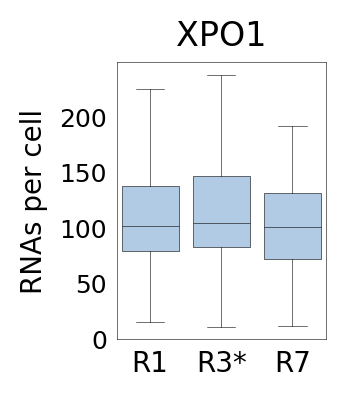

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
thin_line_properties = {
    'linewidth': 0.2  # Set the desired linewidth here
}
colors = ['#b2cbe5','#b2cbe5','#b2cbe5']

fig, ax = plt.subplots(figsize=(1.35, 1.8), dpi=200)
bp = ax.boxplot(
    data_xpo1,
    boxprops=thin_line_properties,
    whiskerprops=thin_line_properties,
    capprops=thin_line_properties,
    positions=[1,2,3],
    medianprops={'linewidth': 0.2, 'color': 'red'},
    vert=True,
    patch_artist=True,
    showfliers=False,
    whis=1.5,
    widths=0.8
)

for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('black')
    box.set_alpha(1)
    
median_colors = ['black']
for median in bp['medians']:
    median.set_color('black')

ax.set_ylabel('RNAs per cell',fontsize=10)

new_tick_positions = [1, 2, 3]
ax.set_xticks(new_tick_positions)
new_labels = ['R1', 'R3*', 'R7']
ax.set_xlim([0.53, 3.47])
ax.set_xticklabels(new_labels, fontsize=10);
ax.tick_params(axis='y', labelsize=9,  length=0.0)
ax.set_title('XPO1');
ax.tick_params(axis='x', length=0.0)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(0.2)

fig.savefig('rna_per_cell_xpo1_V4.svg')

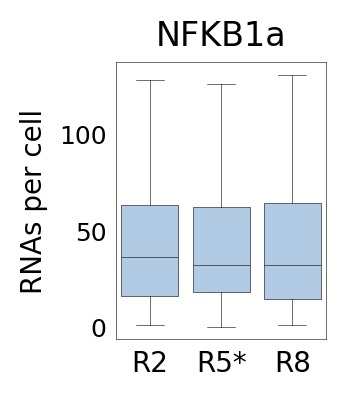

In [41]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
thin_line_properties = {
    'linewidth': 0.2  # Set the desired linewidth here
}
colors = ['#b2cbe5','#b2cbe5','#b2cbe5']

fig, ax = plt.subplots(figsize=(1.35, 1.8), dpi=200)
bp = ax.boxplot(
    data_kraken,
    boxprops=thin_line_properties,
    whiskerprops=thin_line_properties,
    capprops=thin_line_properties,
    positions=[1,2,3],
    medianprops={'linewidth': 0.2, 'color': 'red'},
    vert=True,
    patch_artist=True,
    showfliers=False,
    whis=1.5,
    widths=0.8
)

for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('black')
    box.set_alpha(1)
    
median_colors = ['black']
for median in bp['medians']:
    median.set_color('black')

ax.set_ylabel('RNAs per cell',fontsize=10)

new_tick_positions = [1, 2, 3]
ax.set_xticks(new_tick_positions)
new_labels = ['R2', 'R5*', 'R8']
ax.set_xlim([0.53, 3.47])
ax.set_xticklabels(new_labels, fontsize=10);
ax.tick_params(axis='y', labelsize=9,  length=0.0)
ax.set_title('NFKB1a');
ax.tick_params(axis='x', length=0.0)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(0.2)

fig.savefig('rna_per_cell_nfkb1a_V4.svg')